In [9]:
# 1. Data Loading & Preprocessing (Spark)
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, when, sum, avg, max, rand, explode
import graphframes as gf
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("Assignment1") \
    .config("spark.jars.packages", "graphframes:graphframes:0.8.3-spark3.5-s_2.12") \
    .getOrCreate()

# Read as DataFrame (skip commented lines starting with #)
edges = (
    spark.read.option("comment", "#")
    .option("delimiter", "\t")
    .csv("../Wiki-Vote.txt")
    .select(
        col("_c0").cast("int").alias("src"),
        col("_c1").cast("int").alias("dst")
    )
)

# Get unique vertices
vertices = edges.select("src").union(edges.select("dst")).distinct().withColumnRenamed("src", "id") 

# Create GraphFrame
g = gf.GraphFrame(vertices, edges) 

C:\spark-3.5.5-bin-hadoop3\python\pyspark\sql\dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [2]:
# 2. Basic Graph Statistics
num_nodes = vertices.count()
num_edges = edges.count()

print(f"Number of nodes in graph: {num_nodes}")
print(f"Number of edges in graph: {num_edges}")

Number of nodes in graph: 7115
Number of edges in graph: 103689


C:\spark-3.5.5-bin-hadoop3\python\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


Number of nodes in largest WCC: 7066
Number of edges in largest WCC: 103663


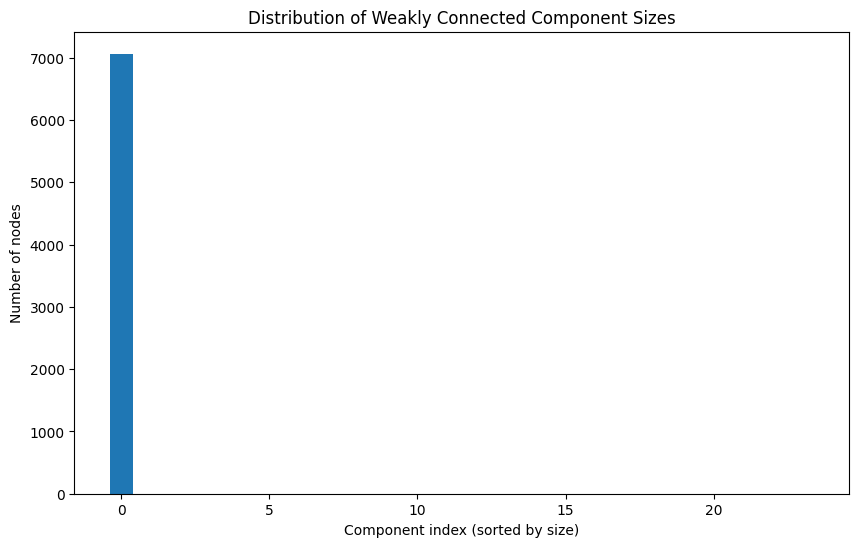

In [13]:
# 3. Weakly Connected Components (WCC)
wcc = g.connectedComponents(algorithm="graphx")

# Count nodes per component
component_sizes = wcc.groupBy("component").count()

# Find the largest component
largest_component = component_sizes.orderBy(desc("count")).first()
largest_comp_id = largest_component["component"]
largest_nodes_count = largest_component["count"]

print("Number of nodes in largest WCC:", largest_nodes_count)

# Filter nodes belonging to largest WCC
largest_wcc_nodes = wcc.filter(col("component") == largest_comp_id)

# Join with edges to get only edges where both src and dst are in largest WCC
largest_wcc_edges = (
    g.edges
    .join(largest_wcc_nodes.select(col("id").alias("src")), on="src")
    .join(largest_wcc_nodes.select(col("id").alias("dst")), on="dst")
)

largest_edges_count = largest_wcc_edges.count()

print("Number of edges in largest WCC:", largest_edges_count)

# Visualize component size distribution 
component_sizes_pdf = component_sizes.orderBy(desc("count")).toPandas()

plt.figure(figsize=(10,6))
plt.bar(range(len(component_sizes_pdf)), component_sizes_pdf["count"])
plt.xlabel("Component index (sorted by size)")
plt.ylabel("Number of nodes")
plt.title("Distribution of Weakly Connected Component Sizes")
plt.show()

C:\spark-3.5.5-bin-hadoop3\python\pyspark\sql\dataframe.py:147: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


Number of nodes in largest SCC: 1300
Number of edges in largest SCC: 39456


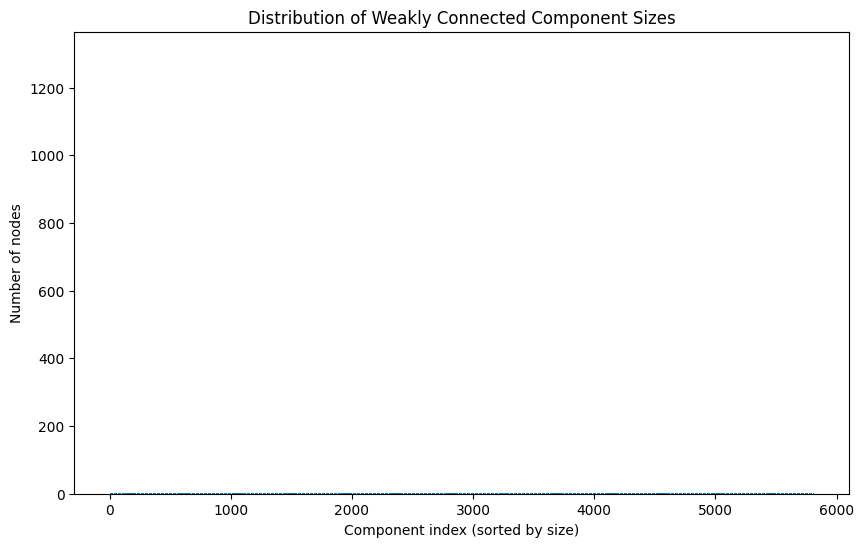

In [16]:
# 4. Strongly Connected Components (SCC)
scc = g.stronglyConnectedComponents(maxIter=10)

# Count nodes per component
component_sizes = scc.groupBy("component").count()

# Find the largest component
largest_component = component_sizes.orderBy(desc("count")).first()
largest_comp_id = largest_component["component"]
largest_nodes_count = largest_component["count"]

print("Number of nodes in largest SCC:", largest_nodes_count)

# Filter nodes belonging to largest SCC
largest_scc_nodes = scc.filter(col("component") == largest_comp_id)

# Join with edges to get only edges where both src and dst are in largest SCC
largest_scc_edges = (
    g.edges
    .join(largest_scc_nodes.select(col("id").alias("src")), on="src")
    .join(largest_scc_nodes.select(col("id").alias("dst")), on="dst")
)

largest_edges_count = largest_scc_edges.count()

print("Number of edges in largest SCC:", largest_edges_count)

# Visualize component size distribution 
component_sizes_pdf = component_sizes.orderBy(desc("count")).toPandas()

plt.figure(figsize=(10,6))
plt.bar(range(len(component_sizes_pdf)), component_sizes_pdf["count"])
plt.xlabel("Component index (sorted by size)")
plt.ylabel("Number of nodes")
plt.title("Distribution of Weakly Connected Component Sizes")
plt.show()


In [5]:
# 5. Clustering Metrics & Triangles

# Count triangles per vertex
triangles = g.triangleCount().select("id", col("count").alias("triangles"))
# Degrees of each vertex
degrees = g.degrees

# Join triangles with degrees # good variable name
vertexStats = triangles.join(degrees, "id")

#-- Compute average clustering coefficient.

# Compute clustering coefficient per vertex
local_clustering_coeff = vertexStats.withColumn(
    "clustering_coeff",
    when(col("degree") > 1,
         ( col("triangles") / ( (col("degree") * (col("degree") - 1)) / 2.0 ) )
    ).otherwise(0.0)
)

avg_clustering_coeff = local_clustering_coeff.agg(avg("clustering_coeff")).collect()[0][0]
print("Average Clustering Coefficient:", avg_clustering_coeff)


#-- Count total number of triangles present.

# Sum over all vertices to get total triangles
total_triangles = triangles.agg(sum("triangles")).collect()[0][0] // 3
print("Total Triangles:", total_triangles)


#-- Computee fraction of closed triangles : total_triangles / total_triplets

total_open_triplets = vertexStats.agg(
    sum((col("degree") * (col("degree") - 1)) / 2.0 - col("triangles"))
).collect()[0][0]

total_triplets = total_triangles + total_open_triplets
fraction_closed_triangles = total_triangles / total_triplets if total_triplets > 0 else 0.0
print("Fraction of Closed Triangles:", fraction_closed_triangles)


Average Clustering Coefficient: 0.13865161827897032
Total Triangles: 608389
Fraction of Closed Triangles: 0.04146055839740732


In [6]:
# 6. Distance-based Metrics

landmarks = [row.id for row in vertices.orderBy(rand()).limit(100).collect()]
# Run shortest paths
shortest_paths = g.shortestPaths(landmarks=landmarks)
# Explode distances map 
distances = (
    shortest_paths
    .select("id", explode("distances").alias("dst", "distance"))
    .filter(col("distance") > 0).orderBy("id", "dst")
)

#-- Compute diameter (maximum shortest path distance)
diameter_result = distances.agg(max("distance")).collect()[0][0]
print(f"Diameter: {diameter_result}")

#-- Approximate effective diameter (90th percentile of distances)
effective_diameter = distances.approxQuantile("distance", [0.9], 0.01)[0]
print("Effective Diameter (90th percentile):", effective_diameter)

Diameter: 9
Effective Diameter (90th percentile): 4.0
